<a href="https://colab.research.google.com/github/ebercab7/fcomputacional/blob/main/Actividad11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Actividad 11**
Solucion numerica a la ecuación de onda

In [2]:
# Bibliotecas a utilizar
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact
from numpy import linspace, zeros
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.integrate import odeint
from scipy.fftpack import diff as psdiff
from moviepy.video.io.bindings import mplfig_to_npimage
import moviepy.editor as mpy

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)1474560/45929032 bytes (3.2%)3866624/45929032 bytes (8.4%)7020544/45929032 bytes (15.3%)10223616/45929032 bytes (22.3%)13541376/45929032 bytes (29.5%)16736256/45929032 bytes (36.4%)20029440/45929032 bytes (43.6%)23175168/45929032 bytes (50.5%)26402816/45929032 bytes (57.5%)29351936/45929032 bytes (63.9%)32473088/45929032 bytes (70.7%)35880960/45929032 bytes (78.1%)3

# **Ejercicio 1:**

Modifique el algoritmo de diferencias finitas empleado anteriormente y resuelva la ecuación de onda amortiguada en una dimensión, dada por la ecuación

\begin{equation*}
\frac{\partial^2 u}{\partial t^2} + 
 b \frac{\partial u}{\partial t}
 = c^2 \left( 
  \frac{\partial^2 u}{\partial x^2}
   \right) \qquad x \in (0,L], t \in (0,T]
\end{equation*}

donde $b \ge 0 $ y $c$ son constantes. 

Se proporcionan las condiciones iniciales y a la frontera para encontrar la solución.

\begin{eqnarray*}
u(x,0) & = & I(x) \\
\frac{\partial}{\partial t} u(x,0) & = & 0 \\
u(0,t) & = & 0 \\
u(L,t) & = & 0 \\
\end{eqnarray*}

Utilice diferencias finitas centradas de segundo orden para aproximar la primer derivada $\partial u/\partial t$.

\begin{equation*}
\frac{\partial}{\partial t} u(x,t) \approx \frac{u(x,t+k) - u(x,t-k)}{2k}
\end{equation*}

Suponga las mismas características del ejemplo presentado anteriormente $L=10$, $c=100$m/s, $t=(0,0.25)$, y coeficiente de amortiguamiento $b=0.5$ con condiciones iniciales $u(x,0) = x(1-x)$ y $\partial u(x,0) / \partial t = 0$ y condiciones a la frontera $u(0,t)=u(L,t)=0$. 

In [3]:
# Función para resolver la ec. de onda
def solver(I, V, f, c, L, Nx, C, b, T, user_action=None):
    """Resuelve u_tt + b*u_t =c^2*u_xx + f sobre (0,L)x(0,T]."""

    x = linspace(0, L, Nx+1) # Malla en x
    dx = x[1] - x[0]
    dt = C*dx/c
    Nt = int(round(T/dt))
    t = linspace(0, Nt*dt, Nt+1) # Malla en t
    C2 = C**2 # Simplificar la ecuación
    A = (b*dt)/2
    
    if f is None or f == 0 :
        f = lambda x, t: 0
    
    if V is None or V == 0:
        V = lambda x: 0

    u = zeros(Nx+1) # Solución al nuevo tiempo
    u_1 = zeros(Nx+1) # Solución 1 paso atrás en el tiempo
    u_2 = zeros(Nx+1) # Solución 2 pasos atrás en el tiempo
    
    import time; 
    #t0 = time.clock() # Mediremos el tiempo de CPU
    t0 = time.process_time()

    # Cargar la condición inicial en u_1
    for i in range(0,Nx+1):
        u_1[i] = I(x[i])

    if user_action is not None:
        user_action(u_1, x, t, 0)
    
    # Fórmula del primer paso
    n = 0
    for i in range(1, Nx):
        u[i] = u_1[i] + dt*V(x[i]) + \
        0.5*C2*(u_1[i-1] - 2*u_1[i] + u_1[i+1]) + \
        0.5*dt**2*f(x[i], t[n])
    u[0] = 0; u[Nx] = 0
    
    if user_action is not None:
        user_action(u, x, t, 1)
    
    # Redefinimos variables para volver a utilizar
    u_2[:], u_1[:] = u_1, u
    
    for n in range(1, Nt):
        # Actualiza los valores en el tiempo t[n+1]
        for i in range(1, Nx):
            u[i] = (1/(A+1))*(2*u_1[i] + (A-1)*u_2[i] + \
            C2*(u_1[i-1] - 2*u_1[i] + u_1[i+1])) + \
            dt**2*f(x[i], t[n])
        # Definimos la condición a la frontera
        u[0] = 0; u[Nx] = 0

        if user_action is not None:
            if user_action(u, x, t, n+1):
                break

        # Redefinimos variables antes del siguiente paso
        u_2[:], u_1[:] = u_1, u

    # cpu_time = t0 - time.clock()
    cpu_time = time.process_time() - t0
    return u, x, t, cpu_time

def user_action(u, x, t, n):
    "Define una acción del usuario para guardar y visualizar posteriormente los datos."
    global user_data
    if 'x' not in user_data:
        user_data['x'] = x
    if 'u' not in user_data:
        user_data['u'] = [(n, u)]
    else:
        user_data['u'].append((t[n], u.copy()))

u.spahe: (1001,)
x.shape: (1001,)
t.shape: (25001,)
CPU time: 103.56101336300001
dt = T/len(user_data[]): 9.99960001599936e-06


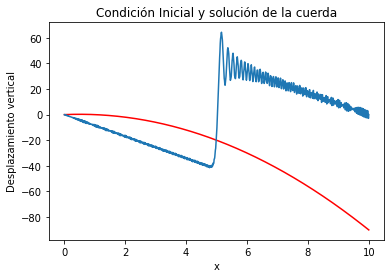

In [5]:
# glosario de variables funcion solver(I, V, f, c, L, Nx, C, b, T)
# I = Condición Incial
# V = Velocidad Inicial
# f = función de forzamiento 
# c = Velocidad de propagación
# L = Longitud de la cuerda
# Nx = Núm. de puntos en x
# C = c*k/h Constante de Courant < 1
# b = constante de amortiguamiento < 1
# T = Tiempo final de Integración

user_data = {}
u, x, t, cpu_time = solver(lambda x: x*(1-x), None, None, 100, 10, 1000, 0.1, 0.5, 0.25, user_action=user_action)

print('u.spahe:', u.shape)
print('x.shape:', x.shape)
print('t.shape:', t.shape)
print('CPU time:',cpu_time)
print('dt = T/len(user_data['u']):', 0.25/len(user_data['u']))

# Graficamos la solución
I = x*(1-x)

plt.xlabel('x')
plt.ylabel('Desplazamiento vertical')
plt.title('Condición Inicial y solución de la cuerda')
plt.plot(x,I,color='red')
plt.plot(x,u)

In [6]:
#animado

from moviepy.video.io.bindings import mplfig_to_npimage
import moviepy.editor as mpy

duration = 20

fig, ax = plt.subplots(figsize=(4, 3), facecolor='white', dpi=92)
plt.tight_layout()

def make_frame_mpl(t):
    n = int(t / duration * (len(user_data['u']) - 1))
    ax.clear()
    x = user_data['x']
    t, u = user_data['u'][n]
    ax.plot(x, u)
    ax.set_title('t = {:.2f}'.format(t))
    ax.set_ylim(-100, 100)
    ax.set_xlabel('x (a. u.)')
    ax.set_ylabel('Desplazamiento vertical (a. u.)')
    return mplfig_to_npimage(fig) # imágen de la figura

animation = mpy.VideoClip(make_frame_mpl, duration=duration)
plt.close(fig)
animation.ipython_display(fps=20, width=600)

100%|█████████▉| 400/401 [00:31<00:00, 12.82it/s]


# **Ejercicio 2:**

Haga el desarrollo del algoritmo de diferencias finitas centradas para resolver la ecuación de onda en 1 dimensión si se tiene un término de forzamiento $f(x,t)$

\begin{equation*}
\frac{\partial^2 u}{\partial t^2} = c^2 \left( 
  \frac{\partial^2 u}{\partial x^2}
   \right) + f(x,t) \qquad x \in (0,L], t \in (0,T]
\end{equation*}

Con las condiciones iniciales y a la frontera para encontrar la solución.

\begin{eqnarray*}
u(x,0) & = & I(x) \\
\frac{\partial}{\partial t} u(x,0) & = & 0 \\
u(0,t) & = & 0 \\
u(L,t) & = & 0 \\
\end{eqnarray*}

$$
  \frac{ u_{j}^{n+1} - 2u_{j}^{n} + u_{j}^{n-1} }{ k^{2} } = c^{2} \frac{ u_{j+1}^{n} - 2u_{j}^{n} - u_{j-1}^{n} }{ h^{2} } + f_{j}^{n}
$$
$f$ depende de la posición y el tiempo. $f( x_{i}, t_{n} )$. Por tanto, despejando $u_{j}^{n+1}:$

$$
  u_{j}^{n+1} = 2u_{j}^{n} - u_{j}^{n-1} + \frac{ k^{2}c^{2} }{ h^{2} }\left[ u_{j+1}^{n} - 2u_{j}^{n} - u_{j-1}^{n} \right] + k^{2} f_{j}^{n}
$$
Una aproximación en base a la derivada para $u_{j}^{-}1$ 

$$
  \frac{\partial u}{\partial t} = \frac{u_{i}^{n+1}-u_{i}^{k-1}}{2k} = v_{0}
$$
Por lo tanto

$$
  u_{i}^{n+1} - u_{i}^{n-1} = 2k*v_{0}, n = 0
$$$$
  u_{i}^{1} - u_{i}^{1} = 2k*v_{0}, n = 0
$$$$
  - u_{i}^{1} = 2k*v_{0} - u_{i}^{1}
$$
En la segunda ecuación:

$$
  u_{j}^{1} = 2u_{j}^{n} - u_{j}^{-1} + \frac{ k^{2}c^{2} }{ h^{2} }\left[ u_{j+1}^{0} - 2u_{j}^{0} - u_{j-1}^{0} \right] + k^{2} f_{j}^{0}
$$$$
  u_{j}^{1} = 2u_{j}^{n} + 2k*v_{0} - u_{i}^{1} + \frac{ k^{2}c^{2} }{ h^{2} }\left[ u_{j+1}^{0} - 2u_{j}^{0} - u_{j-1}^{0} \right] + k^{2} f_{j}^{0}
$$
Despejamos $u_{j}^{1}$:

$$
  u_{j}^{1} + u_{i}^{1} = 2u_{j}^{n} + 2k*v_{0} + \frac{ k^{2}c^{2} }{ h^{2} }\left[ u_{j+1}^{0} - 2u_{j}^{0} - u_{j-1}^{0} \right] + k^{2} f_{j}^{0}
$$$$
  2*u_{j}^{1} = 2u_{j}^{n} + 2k*v_{0} + \frac{ k^{2}c^{2} }{ h^{2} }\left[ u_{j+1}^{0} - 2u_{j}^{0} - u_{j-1}^{0} \right] + k^{2} f_{j}^{0}
$$$$
  u_{j}^{1} = u_{j}^{n} + k*v_{0} + \frac{1}{2}\frac{ k^{2}c^{2} }{ h^{2} }\left[ u_{j+1}^{0} - 2u_{j}^{0} - u_{j-1}^{0} \right] + \frac{k^{2} f_{j}^{0}}{2}
$$

Con esto ya tenemos una expresión para diseñar el algoritmo a seguir.


In [7]:
# Se define una función que resuelve la Ecuación de Onda 

def solver(I, V, f, c, L, Nx, C, T, user_action=None):
    """Resuelve u_tt=c^2*u_xx + f sobre (0,L)x(0,T]."""
    x = linspace(0, L, Nx+1) # Malla en x
    dx = x[1] - x[0]
    dt = C*dx/c
    Nt = int(round(T/dt))
    t = linspace(0, Nt*dt, Nt+1) # Malla en t
    C2 = C**2 # Simplificar la ecuación
    
    if f is None or f == 0 :
        f = lambda x, t: 0
    
    if V is None or V == 0:
        V = lambda x: 0
    u = zeros(Nx+1) # Solución al nuevo tiempo
    u_1 = zeros(Nx+1) # Solución 1 paso atrás en el tiempo
    u_2 = zeros(Nx+1) # Solución 2 pasos atrás en el tiempo
    
    import time; 
    #t0 = time.clock() # Mediremos el tiempo de CPU
    t0 = time.process_time()

    # Cargar la condición inicial en u_1
    for i in range(0,Nx+1):
        u_1[i] = I(x[i])

    if user_action is not None:
        user_action(u_1, x, t, 0)
    
    # Fórmula del primer paso
    n = 0
    for i in range(1, Nx):
        u[i] = u_1[i] + dt*V(x[i]) + \
        0.5*C2*(u_1[i-1] - 2*u_1[i] + u_1[i+1]) + \
        0.5*dt**2*f(x[i], t[n])
    u[0] = 0; u[Nx] = 0
    
    if user_action is not None:
        user_action(u, x, t, 1)
    
    # Redefinimos variables para volver a utilizar
    u_2[:], u_1[:] = u_1, u
    
    for n in range(1, Nt):
        # Actualiza los valores en el tiempo t[n+1]
        for i in range(1, Nx):
            u[i] = - u_2[i] + 2*u_1[i] + \
            C2*(u_1[i-1] - 2*u_1[i] + u_1[i+1]) + \
            dt**2*f(x[i], t[n])
        # Definimos la condición a la frontera
        u[0] = 0; u[Nx] = 0

        if user_action is not None:
            if user_action(u, x, t, n+1):
                break

        # Redefinimos variables antes del siguiente paso
        u_2[:], u_1[:] = u_1, u

    # cpu_time = t0 - time.clock()
    cpu_time = time.process_time() - t0
    return u, x, t, cpu_time

def user_action(u, x, t, n):
    "Define una acción del usuario para guardar y visualizar posteriormente los datos."
    global user_data
    if 'x' not in user_data:
        user_data['x'] = x
    if 'u' not in user_data:
        user_data['u'] = [(n, u)]
    else:
        user_data['u'].append((t[n], u.copy()))

# **Ejercicio 3.**

Resuelva la Ecuación KdV, para el caso de 2 solitones comenzando en $x_1 = 0.25L$ y $x_2 = 0.75L$, con velocidades $c1=0.75$ y $c2=0.01$ e integre hasta que una de las ondas llegue a la frontera.

Grafique las soluciones como en el ejemplo que se proporcionó.

Calculando la solución.
Graficando una representación de la interacción de 2 ondas solitarias.


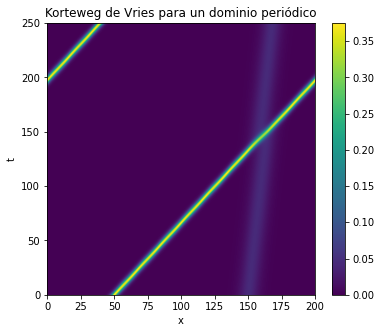

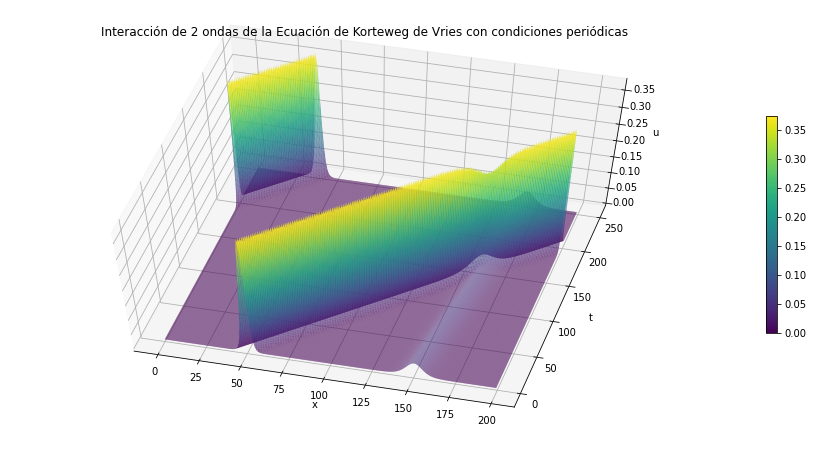

In [9]:
#Solución de la Ecuación de KdV en un dominio periódico

def kdv_exact(x, c):
    """Perfil de la solución exacta de la Ecuación KdV: 1 solitón sobre el eje real"""
    u = 0.5*c*np.cosh(0.5*np.sqrt(c)*x)**(-2)
    return u

def kdv(u, t, L):
    """Las ecuaciones diferenciales de la ecuación KdV, discretizada en x"""
    # Calcula las derivadas en x usando un método pseudoespectral (Transformada de Fourier)
    # Supone tener condiciones periódicas en la dirección x
    ux = psdiff(u, period=L)
    uxxx = psdiff(u, period=L, order=3)

    # Calcula el lado derecho de la ecuación de KdV 
    dudt = -6*u*ux - uxxx
    return dudt

def kdv_solution(u0, t, L):
    """Utiliza la función odeint para integrar la ecuación KdV sobre un dominio periódico.
    `u0` es la condición inicial, `t` es el arreglo de tiempos en los que se evaluará la ecuación, 
     y `L` es el tamaño del dominio periódico en x"""

    sol = odeint(kdv, u0, t, args=(L,), mxstep=5000)
    return sol

if __name__ == "__main__":
    # Define el tamaño del dominio y crea una malla discretizada.
    L = 200.0
    # Preferentemente N=potencia de 2^n (exigencia de la transformada rápida de Fourier FFT)
    Nx = 256

    dx = L / (Nx - 1.0) # dx < 0.8
    x = np.linspace(0, (1-1.0/Nx)*L, Nx) # L < N

    # Definir las condiciones iniciales
    # Dos solitones (ondas solitarias) viajando hacia la derecha en un dominio periódico
    # Un soliton a la izquierda del otro. Posicionados en x-x01 y x-x02, 
    # Con velocidades c1 > c2 que provocará que colisionen entre si (el primero alcance al segundo)
    x01 = 0.25*L
    x02 = 0.75*L
    c1= 0.75
    c2= 0.09
    u0 = kdv_exact(x-x01, c1) + kdv_exact(x-x02, c2) #+ kdv_exact(x02+L/10-x, 0.9*c2)
    
    # Definir el tamaño del dominio en el tiempo
    # Tiempo final T
    T = 250
    Nt = 501
    t = np.linspace(0, T, Nt)

    print("Calculando la solución.")
    sol = kdv_solution(u0, t, L)

    print("Graficando una representación de la interacción de 2 ondas solitarias.")

    import matplotlib.pyplot as plt

    plt.figure(figsize=(6,5))
    plt.imshow(sol[::-1, :], extent=[0,L,0,T])
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('t')
    plt.axis('auto')
    plt.title('Korteweg de Vries para un dominio periódico')
    plt.show()

# Gráfica tipo superfices en 3D en evolución

fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(111, projection='3d')

SX, ST = np.meshgrid(x, t)
# Ver mapa de colores de Matplotlib
# https://matplotlib.org/stable/tutorials/colors/colormaps.html
ax.plot_surface(SX, ST, sol, cmap='viridis', rstride=1, cstride=1, alpha=0.75)

# Grafica una tabla de valores 
m = cm.ScalarMappable(cmap='viridis')
m.set_array(sol)
plt.colorbar(m,shrink=0.5)

ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('u')
ax.view_init(elev=60, azim=-75)
ax.set_title('Interacción de 2 ondas de la Ecuación de Korteweg de Vries con condiciones periódicas')
plt.show()

# **Ejercicio 4:**

Resuelva la Ecuación KdV, para el caso de 3 solitones comenzando en $x_1 = 0.25*L$, $x_2=0.5*L$, y $x_3 = 0.75*L$, con velocidades $c1=0.75$, $c2=0.5$ y $c3=0.25$ e integre hasta que una de las ondas llegue a la frontera.

Grafique las soluciones.

Calculando la solución.
Graficando una representación de la interacción de 2 ondas solitarias.


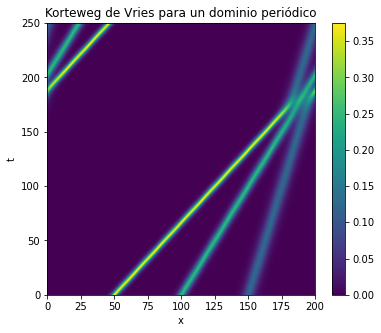

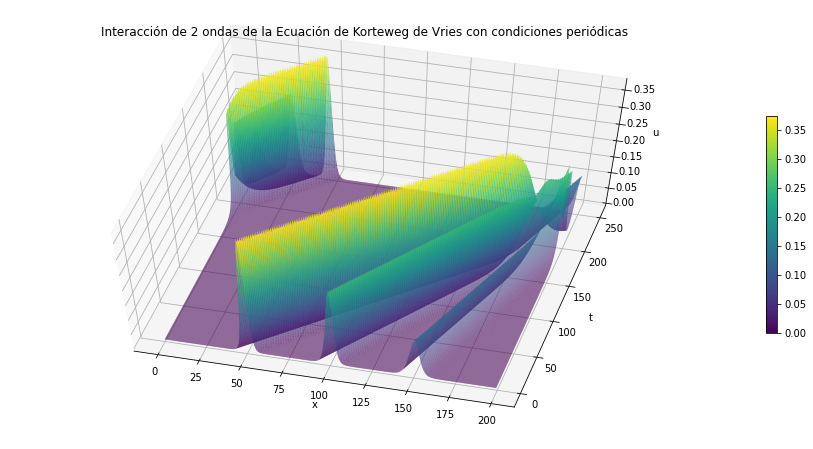

In [10]:
def kdv_exact(x, c):
    """Perfil de la solución exacta de la Ecuación KdV: 1 solitón sobre el eje real"""
    u = 0.5*c*np.cosh(0.5*np.sqrt(c)*x)**(-2)
    return u

def kdv(u, t, L):
    """Las ecuaciones diferenciales de la ecuación KdV, discretizada en x"""
    # Calcula las derivadas en x usando un método pseudoespectral (Transformada de Fourier)
    # Supone tener condiciones periódicas en la dirección x
    ux = psdiff(u, period=L)
    uxxx = psdiff(u, period=L, order=3)

    # Calcula el lado derecho de la ecuación de KdV 
    dudt = -6*u*ux - uxxx
    return dudt

def kdv_solution(u0, t, L):
    """Utiliza la función odeint para integrar la ecuación KdV sobre un dominio periódico.
    `u0` es la condición inicial, `t` es el arreglo de tiempos en los que se evaluará la ecuación, 
     y `L` es el tamaño del dominio periódico en x"""

    sol = odeint(kdv, u0, t, args=(L,), mxstep=5000)
    return sol

if __name__ == "__main__":
    # Define el tamaño del dominio y crea una malla discretizada.
    L = 200.0
    # Preferentemente N=potencia de 2^n (exigencia de la transformada rápida de Fourier FFT)
    Nx = 256

    dx = L / (Nx - 1.0) # dx < 0.8
    x = np.linspace(0, (1-1.0/Nx)*L, Nx) # L < N

    # Definir las condiciones iniciales
    # Dos solitones (ondas solitarias) viajando hacia la derecha en un dominio periódico
    # Un soliton a la izquierda del otro. Posicionados en x-x01 y x-x02, 
    # Con velocidades c1 > c2 que provocará que colisionen entre si (el primero alcance al segundo)
    x01 = 0.25*L
    x02 = 0.50*L
    x03 = 0.75*L
    c1= 0.75
    c2= 0.50
    c3= 0.25
    u0 = kdv_exact(x-x01, c1) + kdv_exact(x-x02, c2) + kdv_exact(x-x03, c3) #+ kdv_exact(x02+L/10-x, 0.9*c2)
    
    # Definir el tamaño del dominio en el tiempo
    # Tiempo final T
    T = 250
    Nt = 501
    t = np.linspace(0, T, Nt)

    print("Calculando la solución.")
    sol = kdv_solution(u0, t, L)

    print("Graficando una representación de la interacción de 2 ondas solitarias.")

    import matplotlib.pyplot as plt

    plt.figure(figsize=(6,5))
    plt.imshow(sol[::-1, :], extent=[0,L,0,T])
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('t')
    plt.axis('auto')
    plt.title('Korteweg de Vries para un dominio periódico')
    plt.show()

# Gráfica tipo superfices en 3D en evolución

fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(111, projection='3d')

SX, ST = np.meshgrid(x, t)
# Ver mapa de colores de Matplotlib
# https://matplotlib.org/stable/tutorials/colors/colormaps.html
ax.plot_surface(SX, ST, sol, cmap='viridis', rstride=1, cstride=1, alpha=0.75)

# Grafica una tabla de valores 
m = cm.ScalarMappable(cmap='viridis')
m.set_array(sol)
plt.colorbar(m,shrink=0.5)

ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('u')
ax.view_init(elev=60, azim=-75)
ax.set_title('Interacción de 2 ondas de la Ecuación de Korteweg de Vries con condiciones periódicas')
plt.show()

# **Ejercicio 5:**

En el ejemplo resuleto anterior, se mostró la evolución de la condición inicial 

\begin{equation*}
u_0^{(2,1)}(x,y,0) = sin (\pi x) \sin (\frac{\pi y}{2})
\end{equation*}

mostrando el *modo (1,2)* de oscilación natural de la membrana ([Ver estas animaciones](https://www.acs.psu.edu/drussell/Demos/MembraneSquare/Square.html)). 
 
En este Ejercicio se pide mostrar la evolución del *modo (1,1)*, con la condición inicial 

\begin{equation*}
u_0^{(1,1)}(x,y,0) = \sin (\frac{\pi x}{2}) \sin (\frac{\pi y}{2})
\end{equation*}

N: 200
D: 0.25
Mx: 50
My 50
dx,dy; 0.04 0.04
nsteps: 200


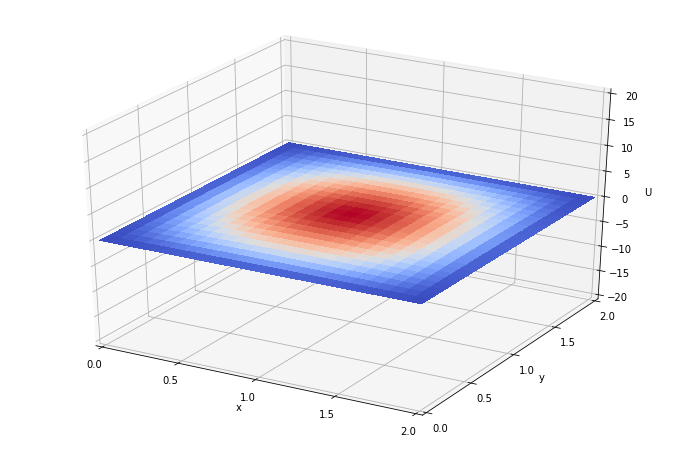

paso: 10.0 t= 0.285


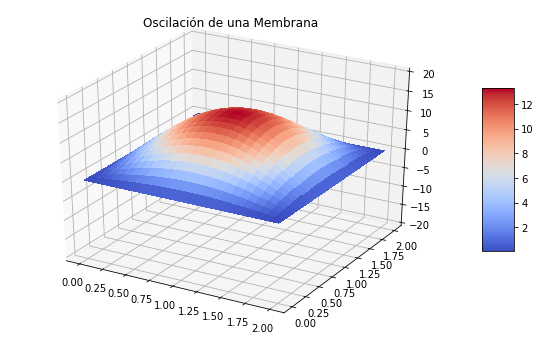

paso: 20.0 t= 0.585


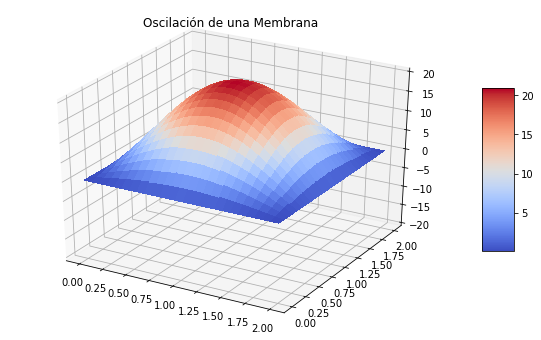

paso: 30.0 t= 0.885


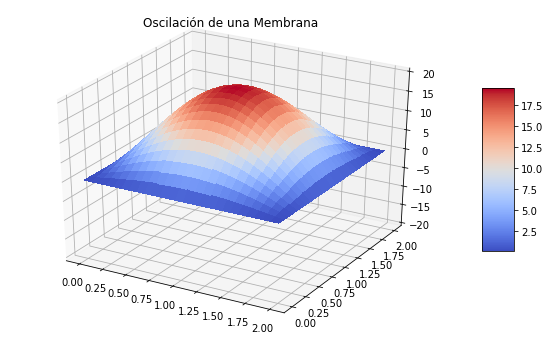

paso: 40.0 t= 1.185


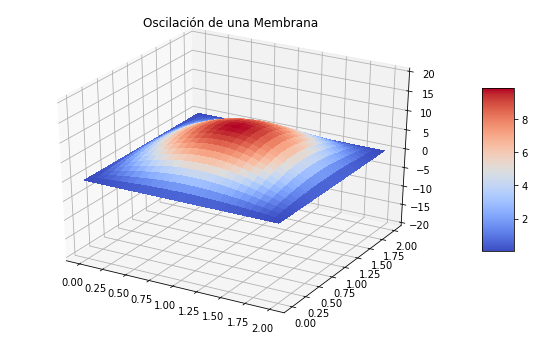

paso: 50.0 t= 1.4849999999999999


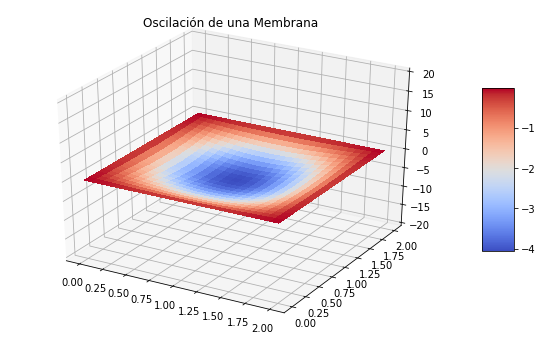

paso: 60.0 t= 1.785


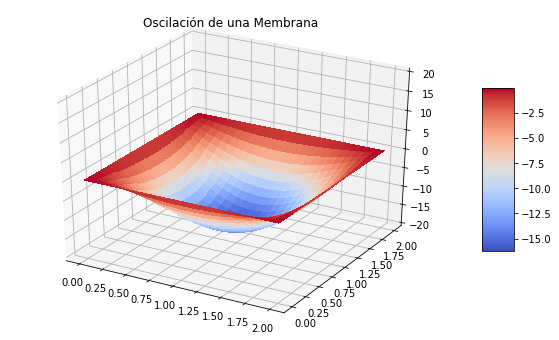

paso: 70.0 t= 2.085


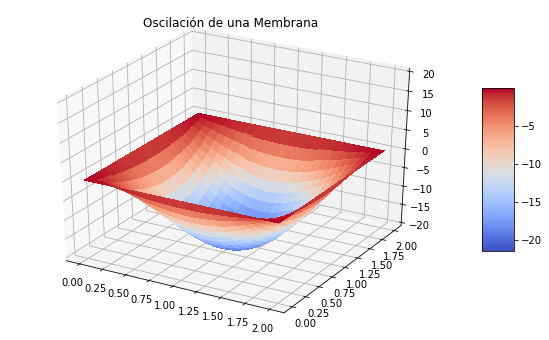

paso: 80.0 t= 2.385


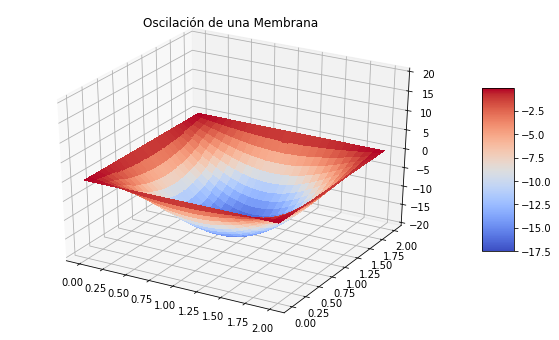

paso: 90.0 t= 2.685


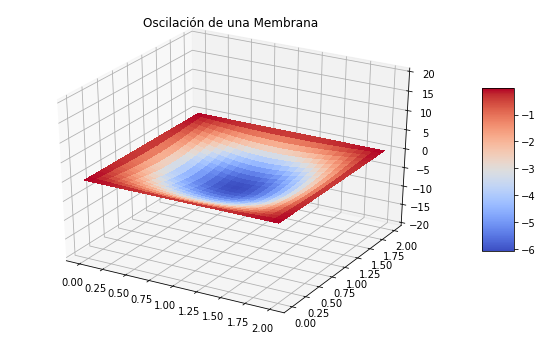

paso: 100.0 t= 2.985


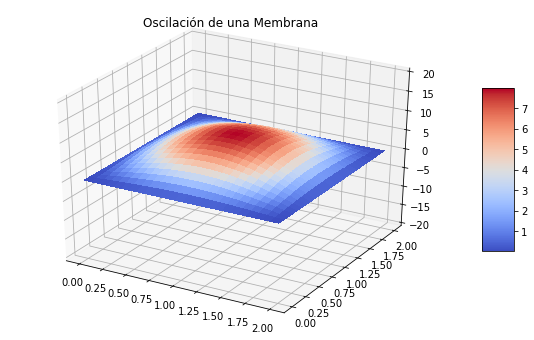

In [11]:
#Solución de la Ecuación de Onda en 2D: Utt = (Uxx+Uyy)
# Método de Diferencias Finitas 

# Se define la Clase general que incluye todas las funciones
class WaveEquationFD:
    
    def __init__(self, N, D, Mx, My):
        self.N = N
        print('N:',N)
        self.D = D
        print('D:',D)
        self.Mx = Mx
        print('Mx:',Mx)
        self.My = My
        print('My',My)
        self.tend = 6
        self.xmin = 0
        self.xmax = 2
        self.ymin = 0
        self.ymax = 2
        self.initialization()
        self.eqnApprox()
           
    def initialization(self):
        self.dx = (self.xmax - self.xmin)/self.Mx
        self.dy = (self.ymax - self.ymin)/self.My
        print('dx,dy;',self.dx,self.dy)
        
        self.x = np.arange(self.xmin, self.xmax+self.dx, self.dx)
        self.y = np.arange(self.ymin, self.ymax+self.dy, self.dy)
        
        #----- Initial condition -----#
        self.u0 = lambda r, s: np.sin(np.pi*r/2)*np.sin(np.pi*s/2)
        
        #----- Initial velocity -----#
        self.v0 = lambda a, b: 0
        
        #----- Boundary conditions -----#
        self.bxyt = lambda left, right, time: 0
        
        self.dt = (self.tend - 0)/self.N
        self.t = np.arange(0, self.tend+self.dt/2, self.dt)
        
        # Assertion for the condition of r < 1, for stability
        r = 4*self.D*self.dt**2/(self.dx**2+self.dy**2);
        assert r < 1, "r is bigger than 1!"

            
    def eqnApprox(self):
        #----- Approximation equation properties -----#
        self.rx = self.D*self.dt**2/self.dx**2
        self.ry = self.D*self.dt**2/self.dy**2
        self.rxy1 = 1 - self.rx - self.ry 
        self.rxy2 = self.rxy1*2

        #----- Initialization matrix u for solution -----#
        self.u = np.zeros((self.Mx+1, self.My+1))
        self.ut = np.zeros((self.Mx+1, self.My+1))
        self.u_1 = self.u.copy()
        
        #----- Fills initial condition and initial velocity -----#
        for j in range(1, self.Mx):
            for i in range(1, self.My):
                self.u[i,j] = self.u0(self.x[i], self.y[j])
                self.ut[i,j] = self.v0(self.x[i], self.y[j])
        
    
    def solve_and_animate(self):
        
        u_2 = np.zeros((self.Mx+1, self.My+1))
        
        xx, yy = np.meshgrid(self.x, self.y)
         
        fig = plt.figure(figsize=(12,8))        
        ax = fig.add_subplot(111, projection='3d')
        #ax = plt.axes(projection ='3d')
        
        wframe = None
        
        k = 0
        nsteps = self.N
        print('nsteps:',nsteps)
        
        while k < nsteps:
            if wframe:
                ax.collections.remove(wframe)
                
            self.t = k*self.dt
            
            #----- Fills in boundary condition along y-axis (vertical, columns 0 and Mx) -----#
            for i in range(self.My+1):
                self.u[i, 0] = self.bxyt(self.x[0], self.y[i], self.t)
                self.u[i, self.Mx] = self.bxyt(self.x[self.Mx], self.y[i], self.t)
                
            for j in range(self.Mx+1):
                self.u[0, j] = self.bxyt(self.x[j], self.y[0], self.t)
                self.u[self.My, j] = self.bxyt(self.x[j], self.y[self.My], self.t)
                
            if k == 0:
                for j in range(1, self.My):
                    for i in range(1, self.Mx):
                        self.u[i,j] = 0.5*(self.rx*(self.u_1[i-1,j] + self.u_1[i+1,j])) \
                                + 0.5*(self.ry*(self.u_1[i,j-1] + self.u_1[i,j+1])) \
                                + self.rxy1*self.u[i,j] + self.dt*self.ut[i,j]
            else:
                for j in range(1, self.My):
                    for i in range(1, self.Mx):
                        self.u[i,j] = self.rx*(self.u_1[i-1,j] + self.u_1[i+1,j]) \
                            + self.ry*(self.u_1[i,j-1] + self.u_1[i,j+1]) \
                            + self.rxy2*self.u[i,j] - u_2[i,j]
                            
            u_2 = self.u_1.copy()
            self.u_1 = self.u.copy()

            wframe = ax.plot_surface(xx, yy, self.u, cmap=cm.coolwarm, linewidth=2, 
                    antialiased=False)
            
            ax.set_xlim3d(0, 2.0)
            ax.set_ylim3d(0, 2.0)
            ax.set_zlim3d(-20, 20)
            
            ax.set_xticks([0, 0.5, 1.0, 1.5, 2.0])
            ax.set_yticks([0, 0.5, 1.0, 1.5, 2.0])
            
            ax.set_xlabel("x")
            ax.set_ylabel("y")
            ax.set_zlabel("U")
            
            plt.pause(0.05)
            k += 0.5
            
            # Sección añadida para hacer gráficas cada 15 pasos 
            if (k < 101 and k%10 == 0):
                print('paso:',k, 't=', self.t)
                # Creating figure
                fig2 = plt.figure(figsize =(10, 6))
                ax2 = plt.axes(projection ='3d')
                # Creating color map
                my_cmap = plt.get_cmap('coolwarm')
                # Creating plot
                surf = ax2.plot_surface(xx, yy, self.u, cmap=cm.coolwarm, linewidth=2, 
                    antialiased=False)
                fig.colorbar(surf, ax = ax2,
                    shrink = 0.5, aspect = 5)
                ax2.set_zlim3d(-20,20)
                ax2.set_title('Oscilación de una Membrana')
                # show plot
                plt.show()

# Se definen los parámetros con los que se va a ejecutar el código     
# N pasos de integración, parámetro de estabilidad < 0.5, Num.Puntos x, Núm.Puntos y

def main():
    simulator = WaveEquationFD(200, 0.25, 50, 50)
    simulator.solve_and_animate() # No funcionó en Google Colab
    plt.show()
    
if __name__ == "__main__":
    main()

# **Ejercicio 6:**

En el mismo contexto que el problema anterior, muestra la evolución de la superposición *modos (3,1)+ (1,3)* dada la condición inicial

\begin{equation*}
u_0^{(3,1)+(1,3)}(x,y,0) = \sin (\frac{3 \pi x}{2}) \sin (\frac{\pi y}{2}) + \sin (\frac{\pi x}{2}) \sin (\frac{3 \pi y}{2})
\end{equation*}

N: 200
D: 0.25
Mx: 50
My 50
dx,dy; 0.04 0.04
nsteps: 200


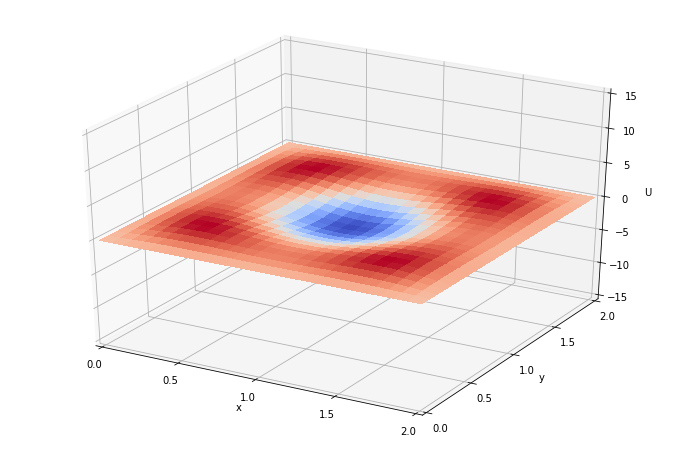

paso: 10.0 t= 0.285


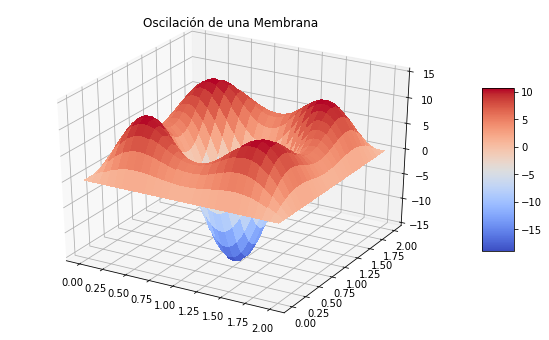

paso: 20.0 t= 0.585


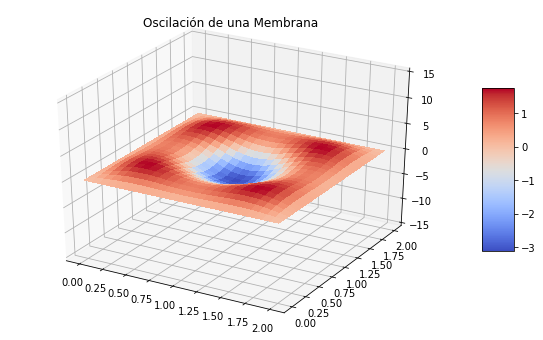

paso: 30.0 t= 0.885


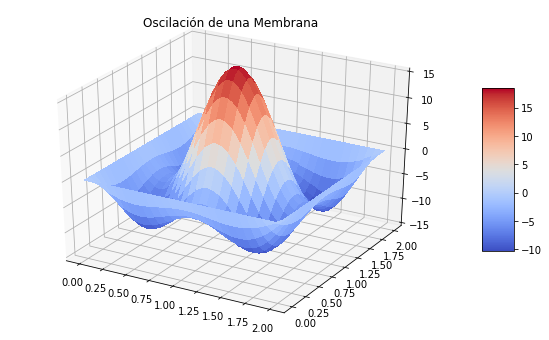

paso: 40.0 t= 1.185


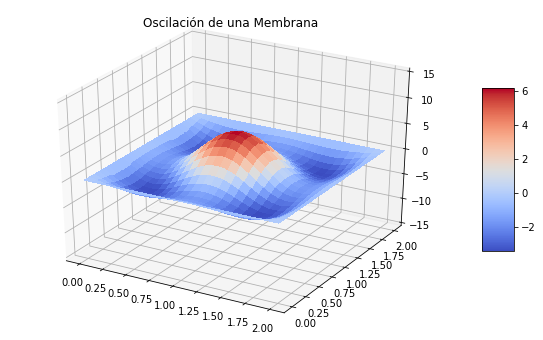

paso: 50.0 t= 1.4849999999999999


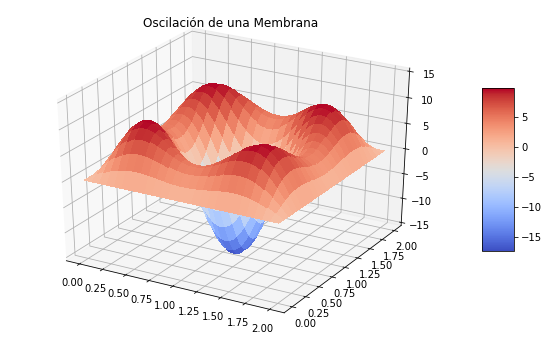

paso: 60.0 t= 1.785


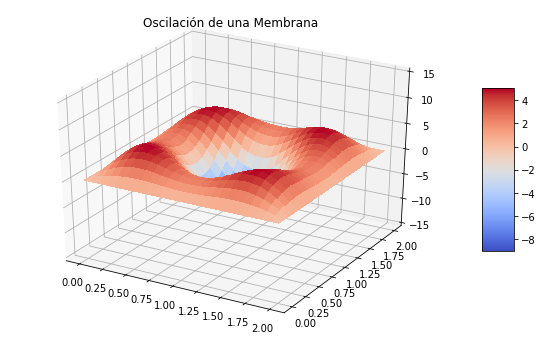

paso: 70.0 t= 2.085


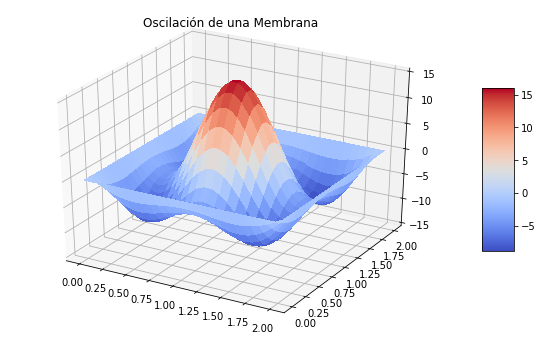

paso: 80.0 t= 2.385


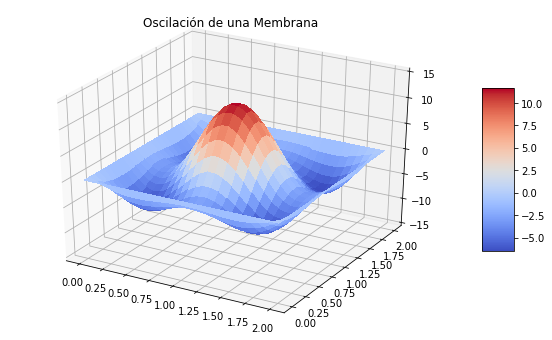

paso: 90.0 t= 2.685


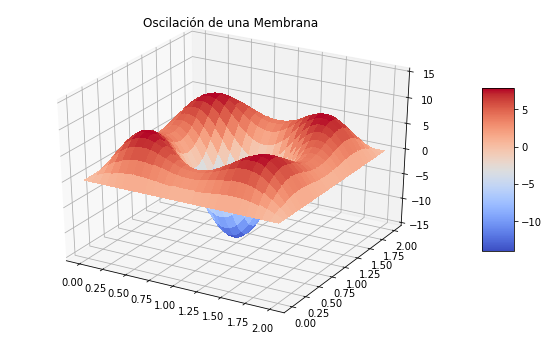

paso: 100.0 t= 2.985


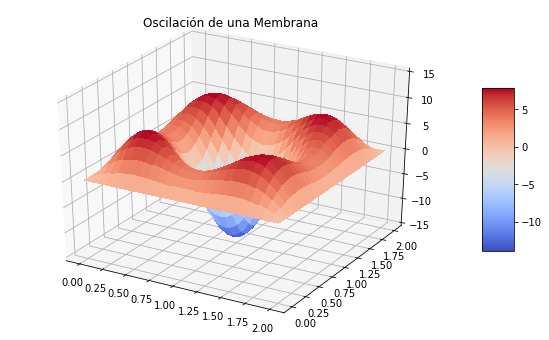

In [12]:
#Solución de la Ecuación de Onda en 2D: Utt = (Uxx+Uyy)
# Método de Diferencias Finitas 

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

# Se define la Clase general que incluye todas las funciones
class WaveEquationFD:
    
    def __init__(self, N, D, Mx, My):
        self.N = N
        print('N:',N)
        self.D = D
        print('D:',D)
        self.Mx = Mx
        print('Mx:',Mx)
        self.My = My
        print('My',My)
        self.tend = 6
        self.xmin = 0
        self.xmax = 2
        self.ymin = 0
        self.ymax = 2
        self.initialization()
        self.eqnApprox()
           
    def initialization(self):
        self.dx = (self.xmax - self.xmin)/self.Mx
        self.dy = (self.ymax - self.ymin)/self.My
        print('dx,dy;',self.dx,self.dy)
        
        self.x = np.arange(self.xmin, self.xmax+self.dx, self.dx)
        self.y = np.arange(self.ymin, self.ymax+self.dy, self.dy)
        
        #----- Initial condition -----#
        self.u0 = lambda r, s: np.sin(3*np.pi*r/2)*np.sin(np.pi*s/2) \
                          + np.sin(np.pi*r/2)*np.sin(3*np.pi*s/2)
        
        #----- Initial velocity -----#
        self.v0 = lambda a, b: 0
        
        #----- Boundary conditions -----#
        self.bxyt = lambda left, right, time: 0
        
        self.dt = (self.tend - 0)/self.N
        self.t = np.arange(0, self.tend+self.dt/2, self.dt)
        
        # Assertion for the condition of r < 1, for stability
        r = 4*self.D*self.dt**2/(self.dx**2+self.dy**2);
        assert r < 1, "r is bigger than 1!"

            
    def eqnApprox(self):
        #----- Approximation equation properties -----#
        self.rx = self.D*self.dt**2/self.dx**2
        self.ry = self.D*self.dt**2/self.dy**2
        self.rxy1 = 1 - self.rx - self.ry 
        self.rxy2 = self.rxy1*2

        #----- Initialization matrix u for solution -----#
        self.u = np.zeros((self.Mx+1, self.My+1))
        self.ut = np.zeros((self.Mx+1, self.My+1))
        self.u_1 = self.u.copy()
        
        #----- Fills initial condition and initial velocity -----#
        for j in range(1, self.Mx):
            for i in range(1, self.My):
                self.u[i,j] = self.u0(self.x[i], self.y[j])
                self.ut[i,j] = self.v0(self.x[i], self.y[j])
        
    
    def solve_and_animate(self):
        
        u_2 = np.zeros((self.Mx+1, self.My+1))
        
        xx, yy = np.meshgrid(self.x, self.y)
         
        fig = plt.figure(figsize=(12,8))        
        ax = fig.add_subplot(111, projection='3d')
        #ax = plt.axes(projection ='3d')
        
        wframe = None
        
        k = 0
        nsteps = self.N
        print('nsteps:',nsteps)
        
        while k < nsteps:
            if wframe:
                ax.collections.remove(wframe)
                
            self.t = k*self.dt
            
            #----- Fills in boundary condition along y-axis (vertical, columns 0 and Mx) -----#
            for i in range(self.My+1):
                self.u[i, 0] = self.bxyt(self.x[0], self.y[i], self.t)
                self.u[i, self.Mx] = self.bxyt(self.x[self.Mx], self.y[i], self.t)
                
            for j in range(self.Mx+1):
                self.u[0, j] = self.bxyt(self.x[j], self.y[0], self.t)
                self.u[self.My, j] = self.bxyt(self.x[j], self.y[self.My], self.t)
                
            if k == 0:
                for j in range(1, self.My):
                    for i in range(1, self.Mx):
                        self.u[i,j] = 0.5*(self.rx*(self.u_1[i-1,j] + self.u_1[i+1,j])) \
                                + 0.5*(self.ry*(self.u_1[i,j-1] + self.u_1[i,j+1])) \
                                + self.rxy1*self.u[i,j] + self.dt*self.ut[i,j]
            else:
                for j in range(1, self.My):
                    for i in range(1, self.Mx):
                        self.u[i,j] = self.rx*(self.u_1[i-1,j] + self.u_1[i+1,j]) \
                            + self.ry*(self.u_1[i,j-1] + self.u_1[i,j+1]) \
                            + self.rxy2*self.u[i,j] - u_2[i,j]
                            
            u_2 = self.u_1.copy()
            self.u_1 = self.u.copy()

            wframe = ax.plot_surface(xx, yy, self.u, cmap=cm.coolwarm, linewidth=2, 
                    antialiased=False)
            
            ax.set_xlim3d(0, 2.0)
            ax.set_ylim3d(0, 2.0)
            ax.set_zlim3d(-15, 15)
            
            ax.set_xticks([0, 0.5, 1.0, 1.5, 2.0])
            ax.set_yticks([0, 0.5, 1.0, 1.5, 2.0])
            
            ax.set_xlabel("x")
            ax.set_ylabel("y")
            ax.set_zlabel("U")
            
            plt.pause(0.05)
            k += 0.5
            
            # Sección añadida para hacer gráficas cada 15 pasos 
            if (k < 101 and k%10 == 0):
                print('paso:',k, 't=', self.t)
                # Creating figure
                fig2 = plt.figure(figsize =(10, 6))
                ax2 = plt.axes(projection ='3d')
                # Creating color map
                my_cmap = plt.get_cmap('coolwarm')
                # Creating plot
                surf = ax2.plot_surface(xx, yy, self.u, cmap=cm.coolwarm, linewidth=2, 
                    antialiased=False)
                fig.colorbar(surf, ax = ax2,
                    shrink = 0.5, aspect = 5)
                ax2.set_zlim3d(-15, 15)
                ax2.set_title('Oscilación de una Membrana')
                # show plot
                plt.show()

# Se definen los parámetros con los que se va a ejecutar el código     
# N pasos de integración, parámetro de estabilidad < 0.5, Num.Puntos x, Núm.Puntos y

def main():
    simulator = WaveEquationFD(200, 0.25, 50, 50)
    simulator.solve_and_animate() # No funcionó en Google Colab
    plt.show()
    
if __name__ == "__main__":
    main()